# The 10 steps of a Data Science project

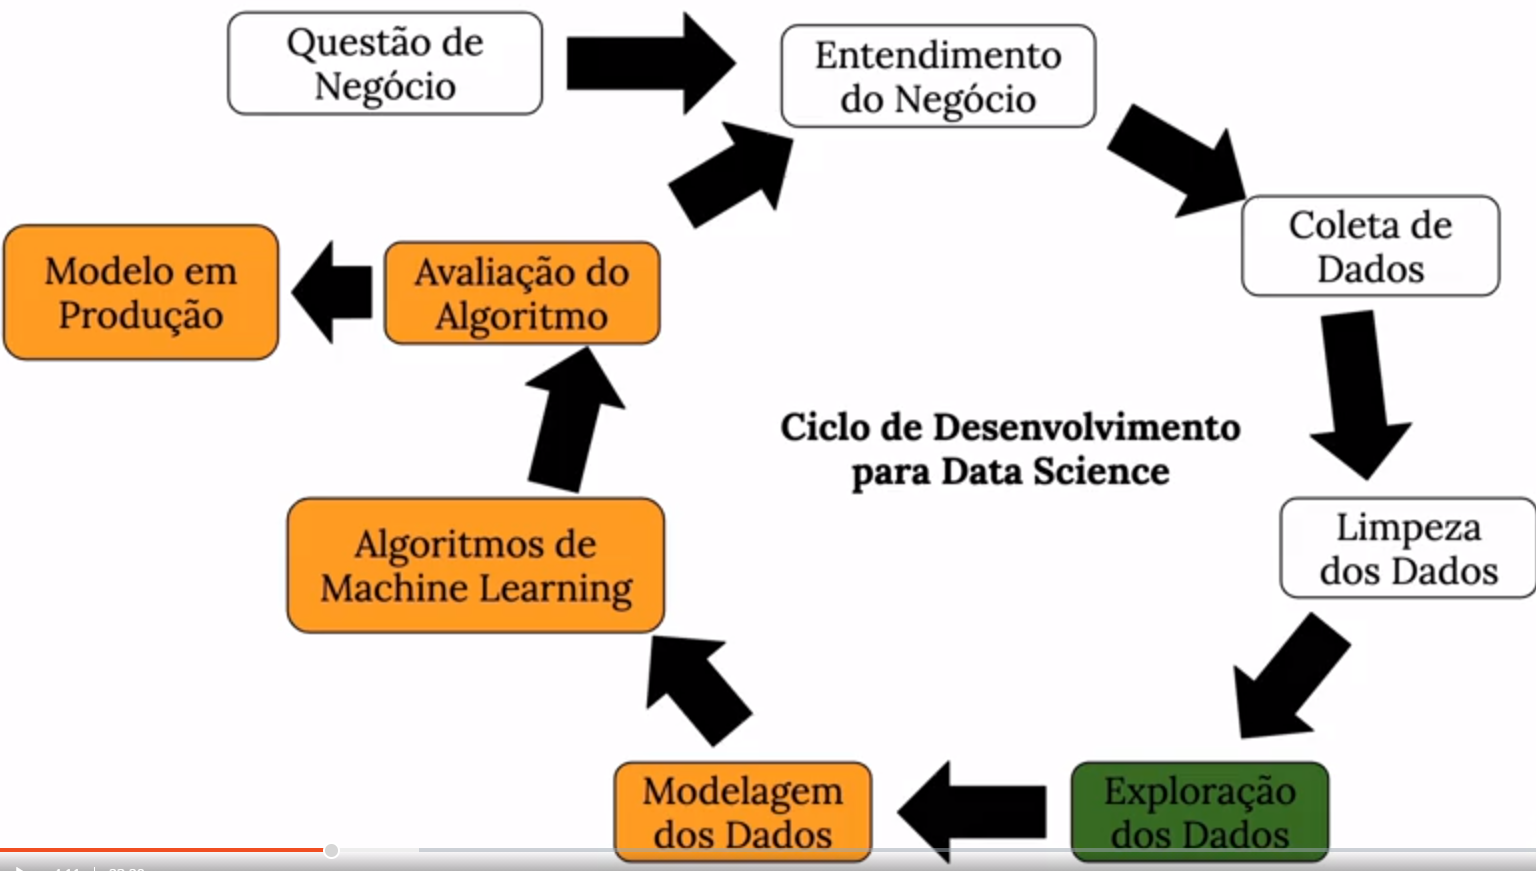

In [288]:
Image('img/01.png')

# Understanding the business problem with 4 questions

* Entender a motivação:

    -- Qual o contexto?
* Entender a causa raiz do problema:

    -- Porque fazer uma previsão de vendas?
* Entender quem é o dono do problema:

    -- Quem será o StakeHolder?
* Entender o formato da solução:

    -- Qual o formato da solução?
        -- Granularidade (previsão semanal, mensal, anual, por loja, por produto, por categoria, etc)
        -- Tipo do problema (classificação, previsão, clusterização, etc)
        -- Potenciais métodos (rede neural, time series, regressão, etc)
        -- Formato da entrega (dashboard, csv, email, etc)


# O método de gerenciamento CRISP-DS

# Descriptive Analysis

* Quantidade de dados:

    --Servidores? Clusters? Spark? Hadoop?
* Tipos de variáveis:

    -- % Numérica, % Categórica, % Temporal
* Quantidade de dados faltantes:

    -- Qual é o volume de dados NA?
    -- Qual a razão de faltas dados?
    -- Sistema? Input manual?
* Resumo Geral dos Dados:

    -- Estatistica descritiva

# Rossmann Store Sales

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

# Data fields
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0. Imports

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import inflection
import math
import datetime

from scipy                     import stats as ss
from boruta                    import BorutaPy
from matplotlib                import pyplot as plt
from IPython.core.display      import display, HTML
from IPython.display           import Image

import xgboost as xgb

from sklearn.preprocessing     import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.ensemble          import RandomForestRegressor

## 0.1. Helper functions

In [11]:
def jupyter_settings():
    
    !matplotlib inline
    !pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 12
    
    display(HTML("<style>.container { width:95% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [12]:
jupyter_settings()

'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 0.2. Loading data

In [15]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [16]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Data Description

## 1.1. Rename columns

In [17]:
df1 =  df_raw.copy()

In [18]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [19]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

In [20]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data dimentions

In [21]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data types

In [22]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [23]:
df1['date'] = pd.to_datetime(df1['date'])

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [25]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. NA Fillout

In [26]:
# competition_distance ### larger distances being considerated as the highest competition
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month --> filling with present values, which will count as 0 time of competition
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year --> filling with present values, which will count as 0 time of competition
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_weew --> filling with present values, which will count as 0 time of promo           
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year--> filling with present values, which will count as 0 time of promo        
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval 
df1['promo_interval'].fillna(0, inplace=True)

In [27]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0


In [28]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [29]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [30]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [31]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change type

In [151]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [33]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
                                                                              

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

Metrics: Dispersion (Gauss, std, range, kurtosis, skewness) and Central Tendency (mean, median).

In [35]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [36]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [37]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [38]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


### 1.7.1. Numerical Attributes

In [39]:
# Cemtral tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

In [42]:
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [43]:
# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

** Um detalhe para projetos futuros seria renomear os valores das variaveis categoricasja aqui e não na etape da feature engineering.

In [44]:
cat_attributes.apply(lambda x: x.unique().shape)

,state_holiday,store_type,assortment,promo_interval,month_map
0,4,4,3,4,12


<AxesSubplot:xlabel='assortment', ylabel='sales'>

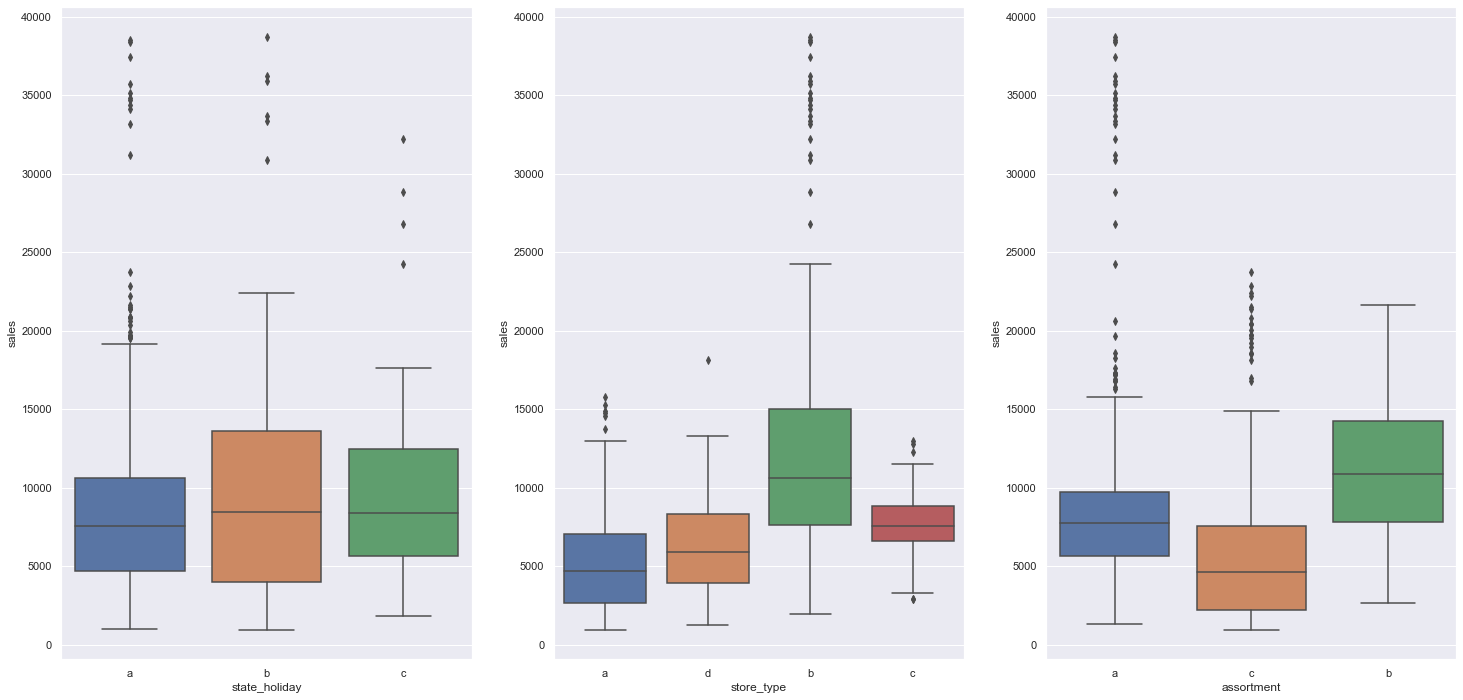

In [45]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2. Feature Engineering

## 2.1. Mind Map and Hypothesis creation

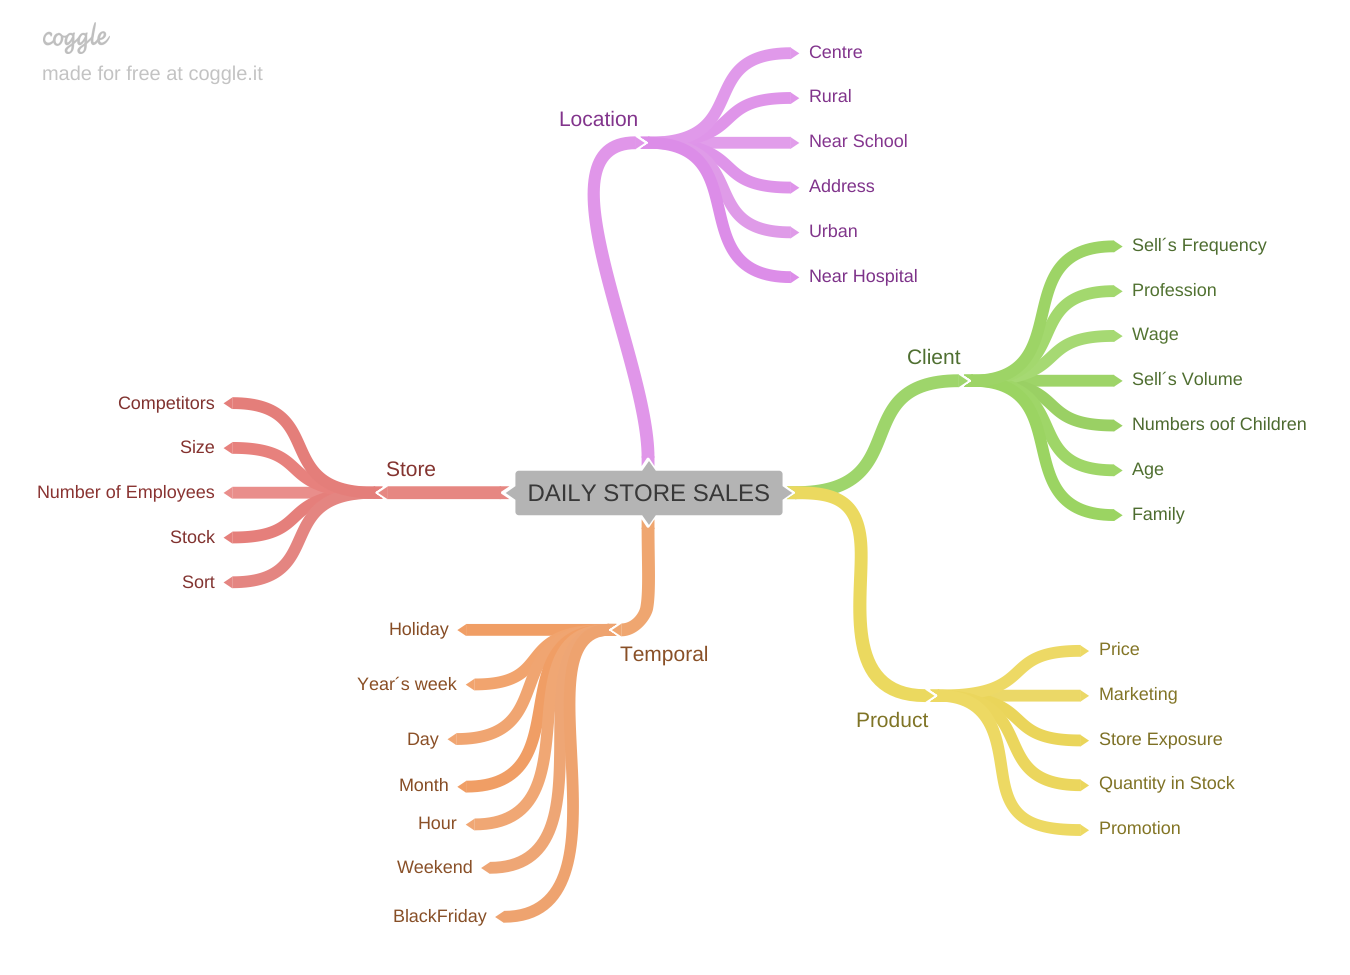

In [66]:
Image('Img/mindmap.png')

### 2.1.1. Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com mais sortimento deveriam vender mais

**5.** Lojas com mais competidores proximos deveriam vender menos

**6.** Lojas com mais competidores a mais tempo deveriam vender mais

### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expôem mais o produto deveriam vender mais

**3.** Lojas com produtos com preços menores deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempos deveriam vender mais

**6.** Lojas com mais dias de promoções deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas  deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares


## 2.2. Final hypothesis list

4. Lojas com mais sortimento deveriam vender mais
5. Lojas com mais competidores proximos deveriam vender menos
6. Lojas com mais competidores a mais tempo deveriam vender mais

5. Lojas com promoções ativas por mais tempos deveriam vender mais

6. Lojas com mais dias de promoções deveriam vender mais

7. Lojas com mais promoções consecutivas deveriam vender mais

1. Lojas abertas durante o feriado de Natal deveriam vender mais

2. Lojas deveriam vender mais ao longo dos anos

3. Lojas deveriam vender mais no segundo semestre do ano

4. Lojas deveriam vender mais depois do dia 10 de cada mês

5. Lojas deveriam vender menos aos finais de semana

6. Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [167]:
df1['date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: date, Length: 1017209, dtype: datetime64[ns]

In [46]:
df2 = df1.copy()

In [47]:
df2['date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: date, Length: 1017209, dtype: datetime64[ns]

In [170]:
# df2.to_json('csv/df2.json')

In [48]:
df2 = pd.read_json('csv/df2.json')

In [49]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [50]:
type(df2['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

### 2.3.1. Time Features

In [51]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of the year
df2['week_of_the_year'] = df2['date'].dt.isocalendar().week
# year - week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

### 2.3.2. Competition time Features

In [52]:
# competition since --> creating a variable for the time passed since the competition started 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

### 2.3.3. Promotion time Features

In [53]:
# promo since --> creating a variable for the time passed since the promotion started
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

### 2.3.4. Assortment feature

In [54]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

### 2.3.5. Holiday Features

In [55]:
# state holiday
df2['state_holiday'] =  df2['state_holiday'].apply(lambda x: 'Public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'Regular day')

In [56]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,Regular day,Regular day,Regular day,Regular day,Regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. Data Filter

In [57]:
df3 = df2.copy()

In [ ]:
# df3.to_json('csv/df3.json')

In [ ]:
df3 = pd.read_json('csv/df3.json')

In [58]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_the_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,Regular day,1,c,basic,1270,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,Regular day,1,a,basic,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,Regular day,1,a,basic,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,Regular day,1,c,extended,620,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,Regular day,1,a,basic,29910,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3. Rows Filtering

In [59]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3. Columns Filter

In [60]:
# customers is unnecessary due to unpredictability
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [61]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_the_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4. EDA

* Como as variaveis impactam o fenômeno? e qual a magnitude desse impacto? variáveis importantes para o modelo.
* Os 3 Objetivos da análise exploratória de dados:

**1.** Adquirir experiência de negócio.

**2.** Validar hipóteses de negócio (Insights).

**3.** Perceber as variáveis que são importantes para o modelo.

* Tipos de análise:

**1.** Análise univariada: Como é essa variável (min, max, distribuição, range...)

**2.** Análise Bivariada: Como a variável impacta na resposta? (correlação, validação de hipóteses...)

**3.** Análise multivariada: Como as variáveis se relacionam? 

In [62]:
df4 = df3.copy()

In [186]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_the_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,Regular day,1,c,basic,1270,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,Regular day,1,a,basic,570,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,Regular day,1,a,basic,14130,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,Regular day,1,c,extended,620,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,Regular day,1,a,basic,29910,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [63]:
df4.to_json('csv/df4.json')

In [189]:
df4 = pd.read_json('csv/df4.json')

## 4.1. Univariate analysis

### 4.1.1. Response variable

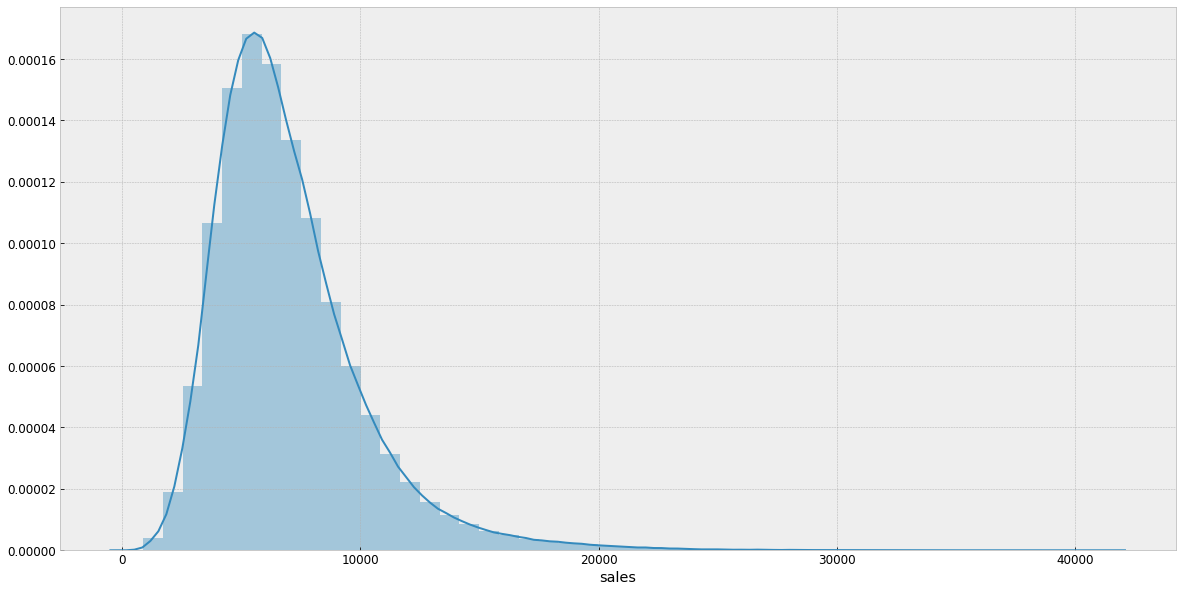

In [191]:
plt.figure(figsize=(20, 10))
sns.distplot(df4['sales'])

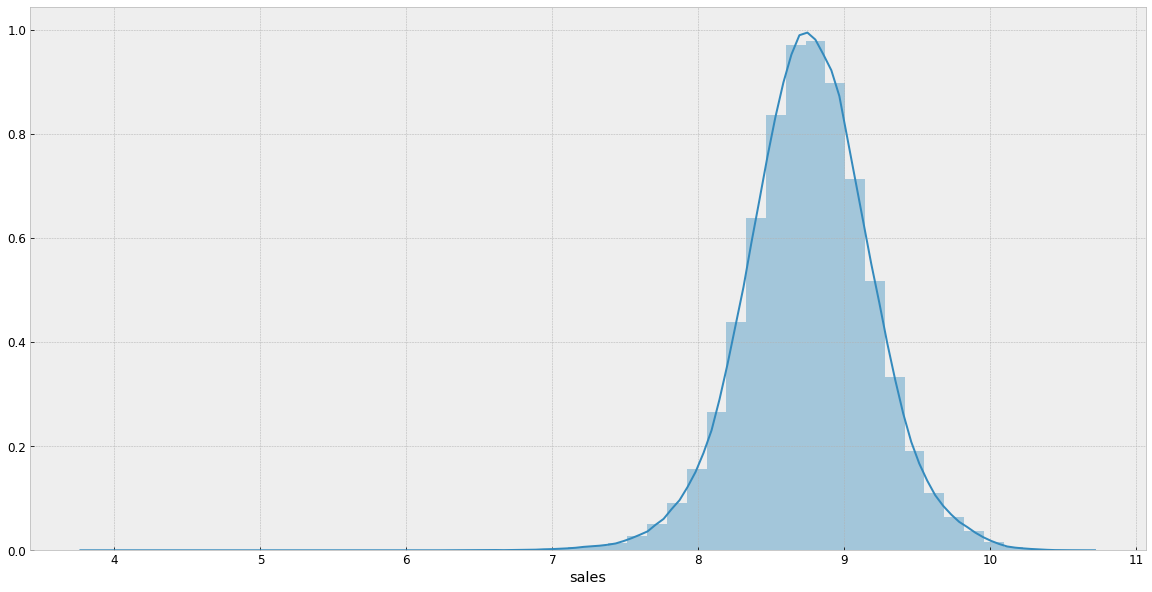

In [192]:
plt.figure(figsize=(20, 10))
sns.distplot(np.log1p(df4['sales']))

In [77]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_the_year                         int64
year_week                               object
competition_s

In [78]:
num_attributes = df4.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]', 'UInt32'])

### 4.1.2. Numerical variables

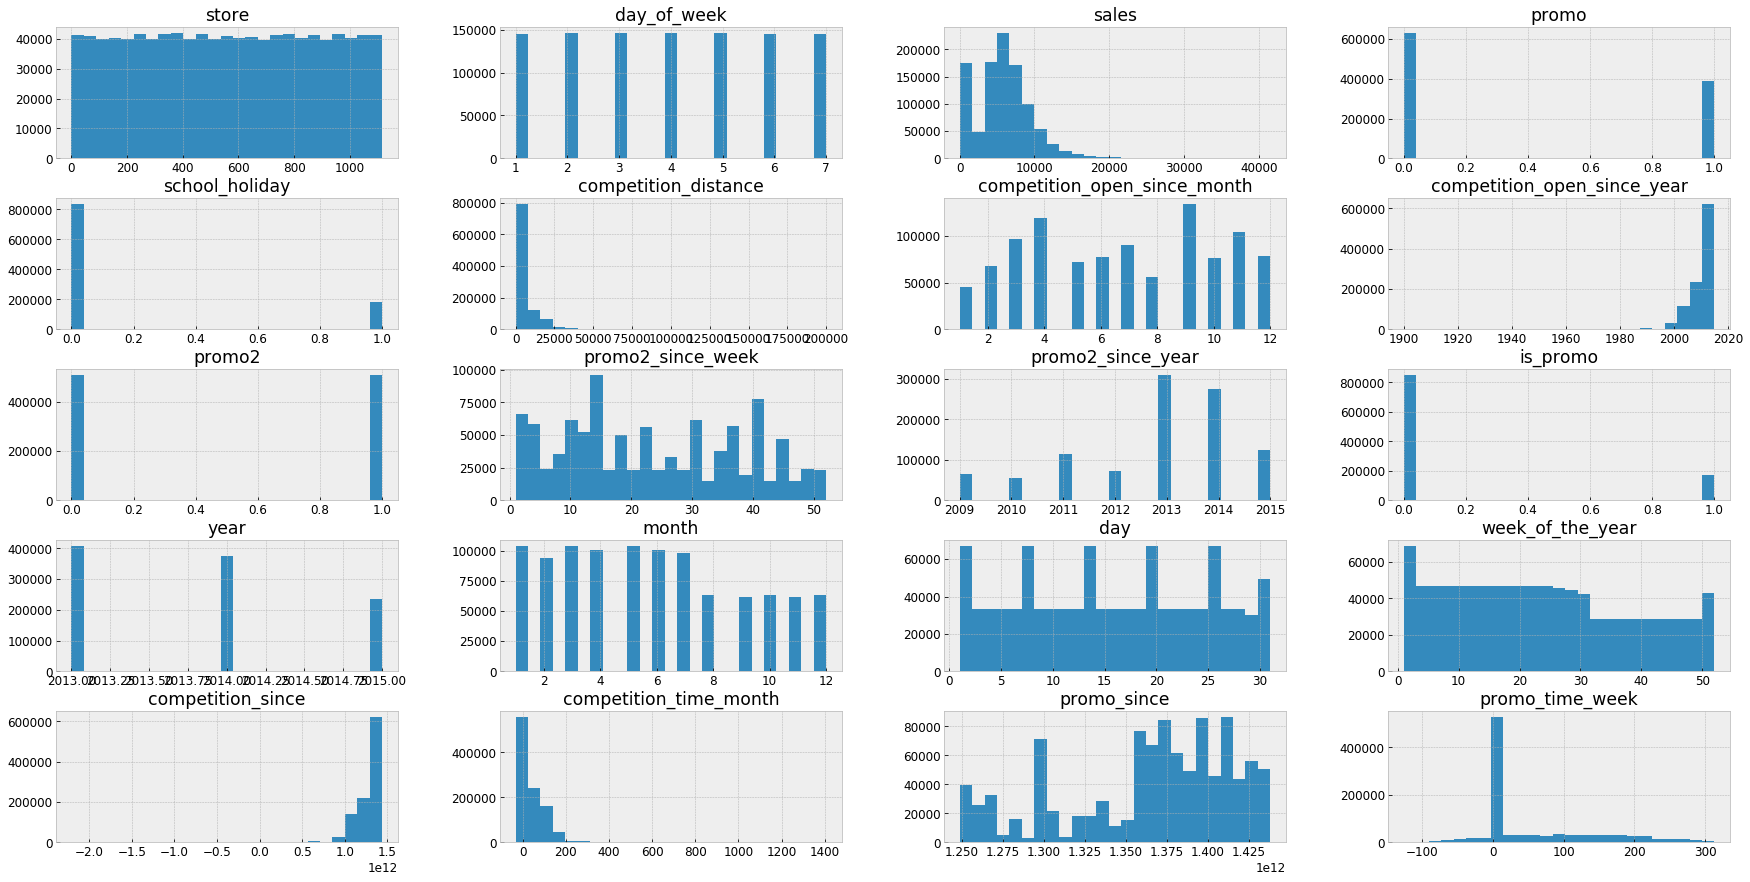

In [79]:
num_attributes.hist(figsize=(30,15), bins=25);

### 4.1.3. Categorical variables

In [80]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,Regular day,c,basic,2015-30
1,Regular day,a,basic,2015-30
2,Regular day,a,basic,2015-30
3,Regular day,c,extended,2015-30
4,Regular day,a,basic,2015-30


In [81]:
df4['state_holiday'].drop_duplicates()

0            Regular day
63555     Public holiday
129340    Easter holiday
241055         Christmas
Name: state_holiday, dtype: object

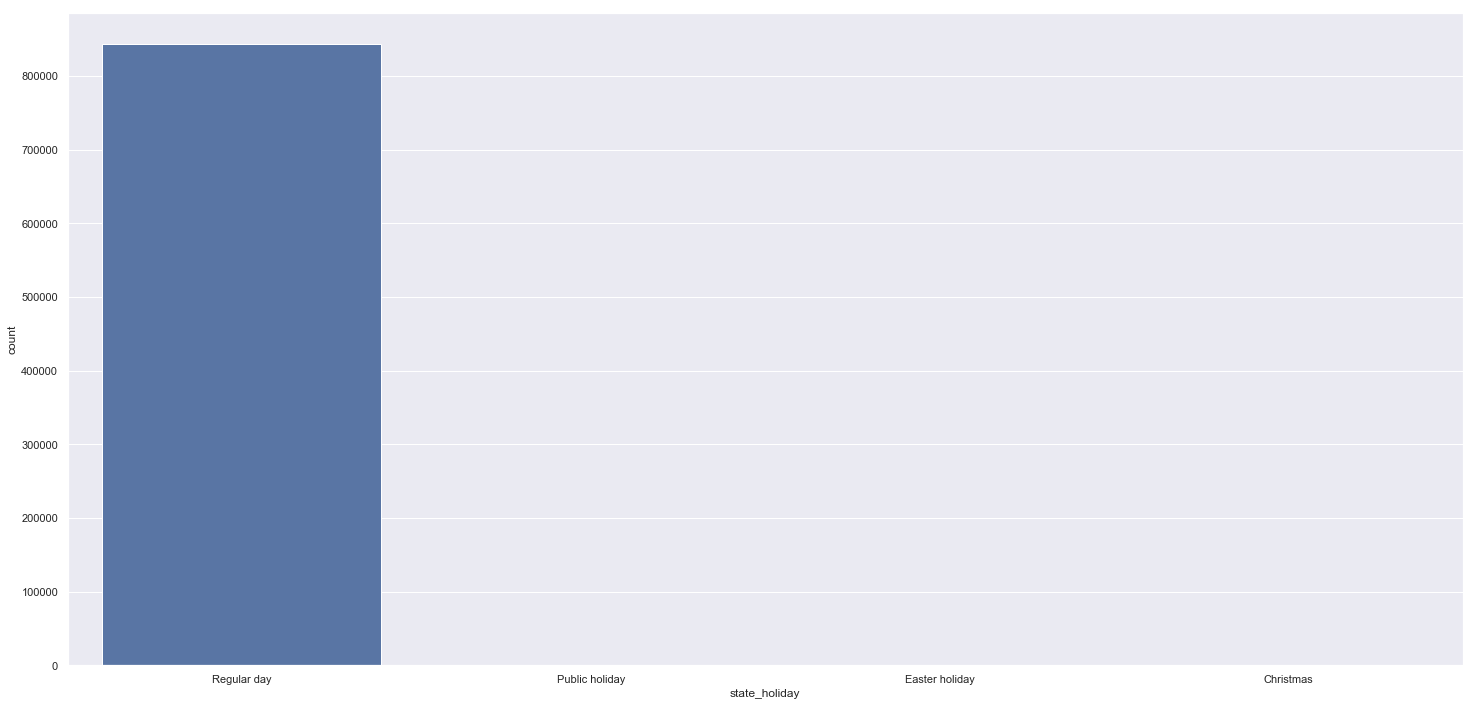

In [291]:
# state_holiday
sns.countplot(df4['state_holiday'])

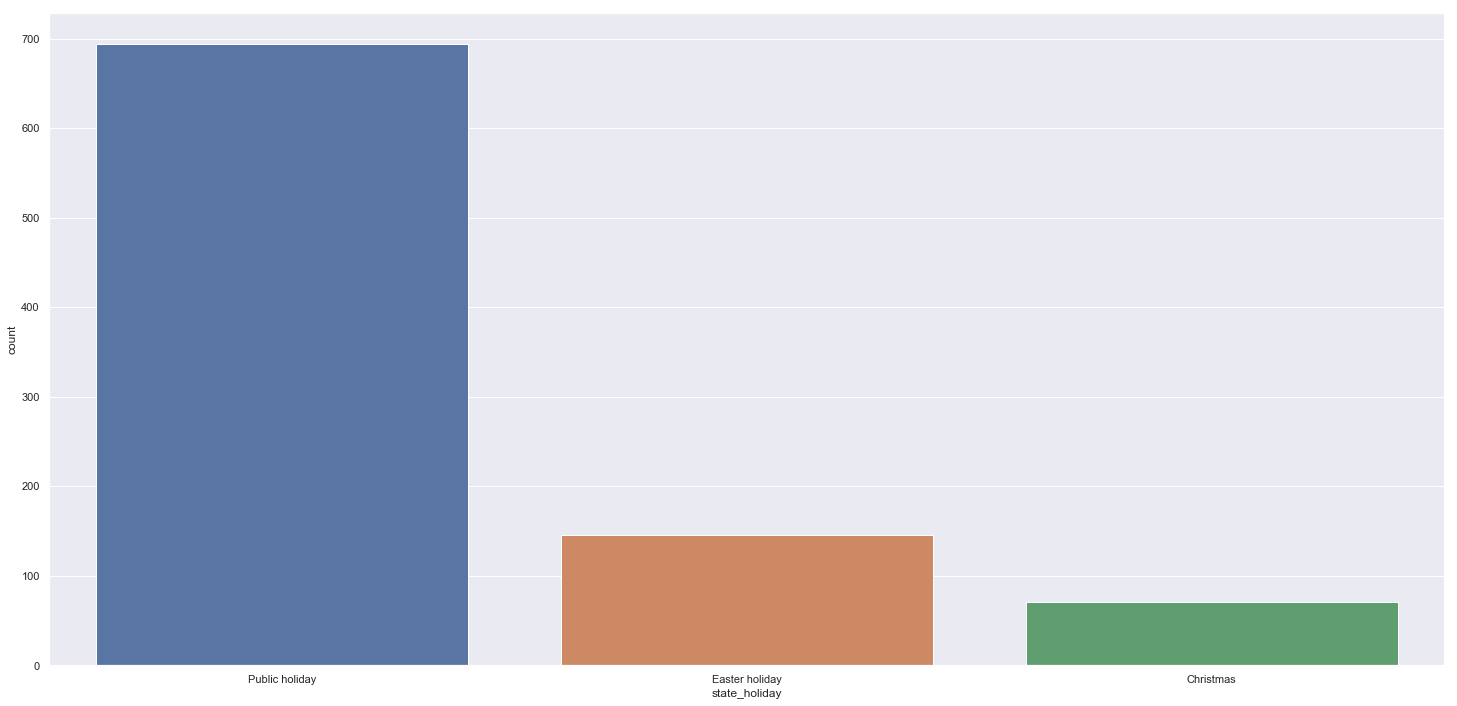

In [290]:
# state_holiday
a = df4[df4['state_holiday'] != 'Regular day']

sns.countplot(a['state_holiday'])

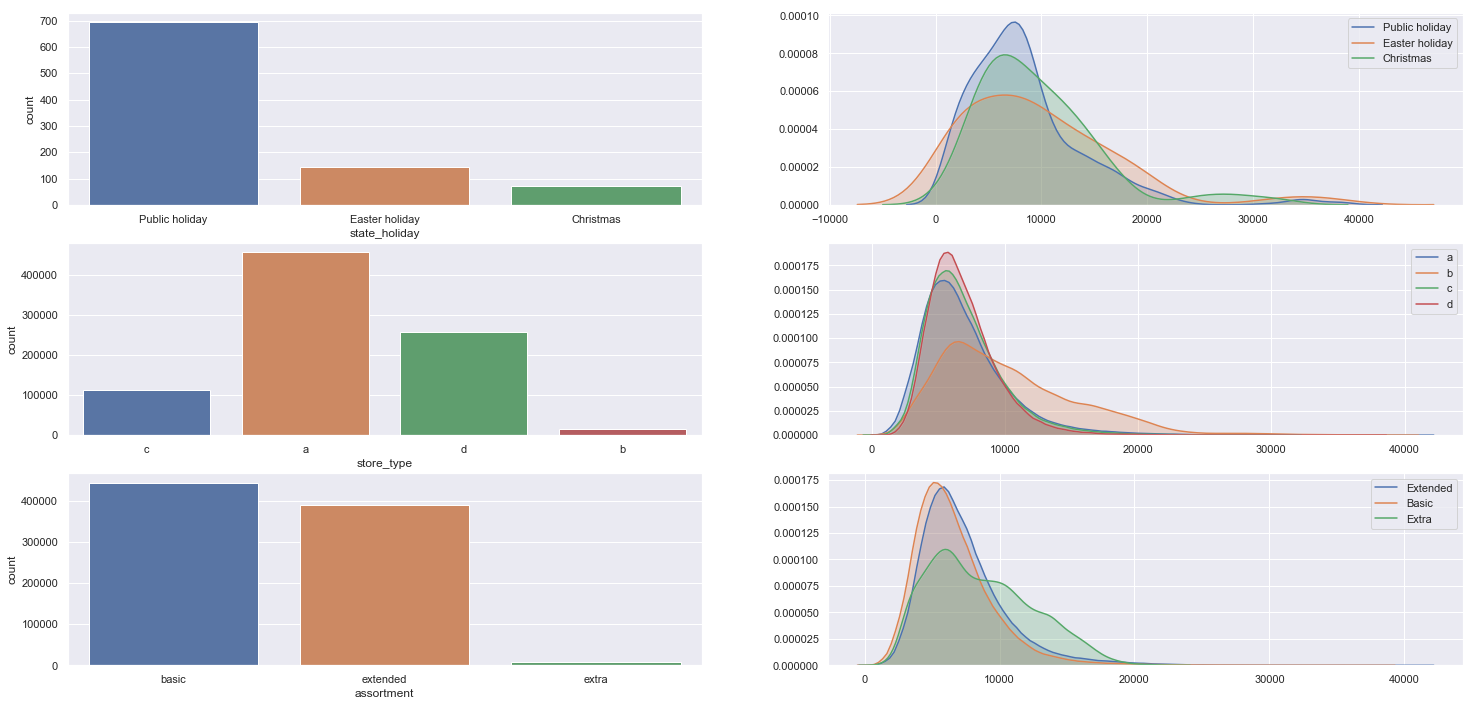

In [293]:
# state_holiday

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'Regular day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'Public holiday']['sales'], label='Public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True)

# Store type

plt.subplot( 3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment

plt.subplot( 3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True)

## 4.2. Bivariate analysis

### H1. stores with higher sortiment should be selling more

* Relative to other types of sortiment, the 'extra', which is considered the ones with highest sortiment, sell more. But in relation to the total of sell, it sells less then others.

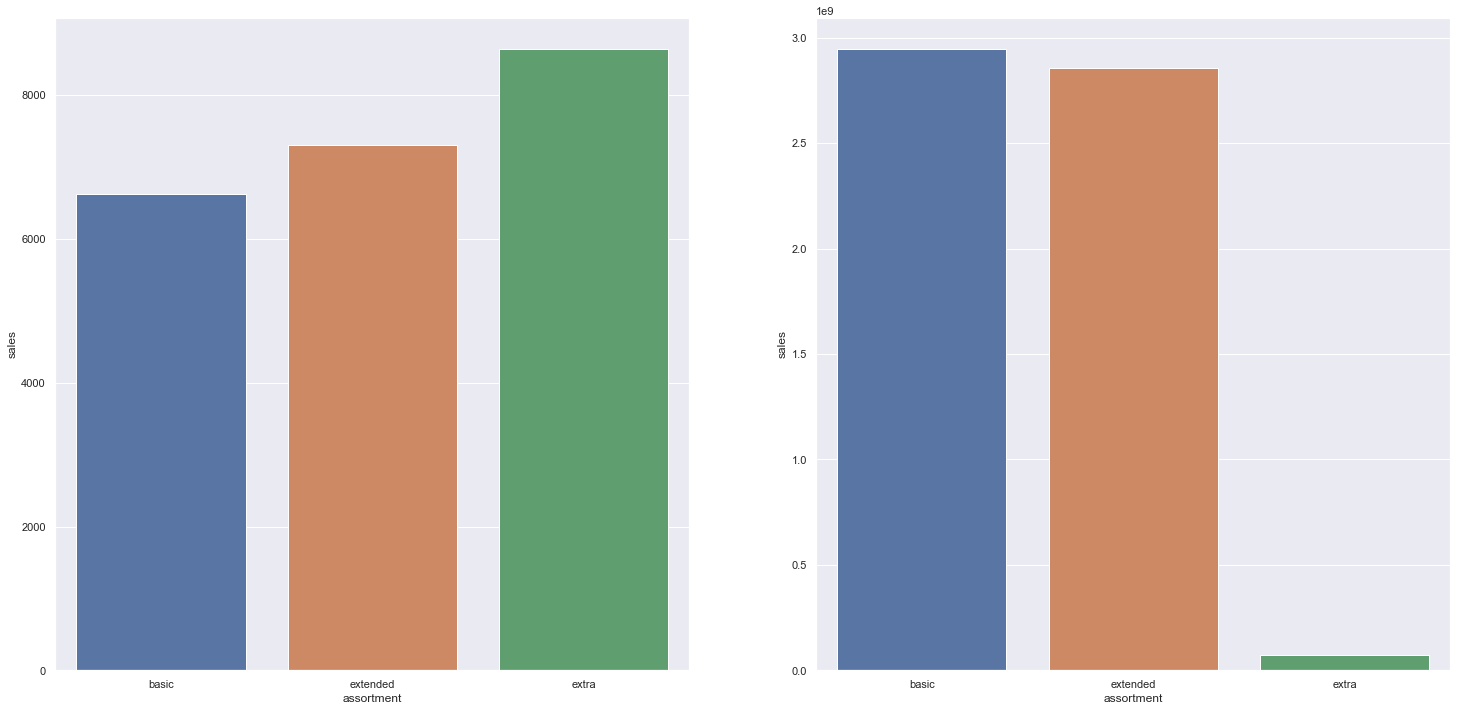

In [294]:
# assortment 'extra' sells more relative to other assortments, but less in total, for being a minority in the assortment category.
aux1_mean = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='assortment', y='sales', data=aux1_mean)

plt.subplot(1,2,2)
sns.barplot(x='assortment', y='sales', data=aux1)

In [86]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [87]:
aux2.pivot(index='year_week', columns='assortment', values='sales')

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


In [88]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061
...,...,...,...
398,2015-26,extra,684180
401,2015-27,extra,586036
404,2015-28,extra,632017
407,2015-29,extra,574020


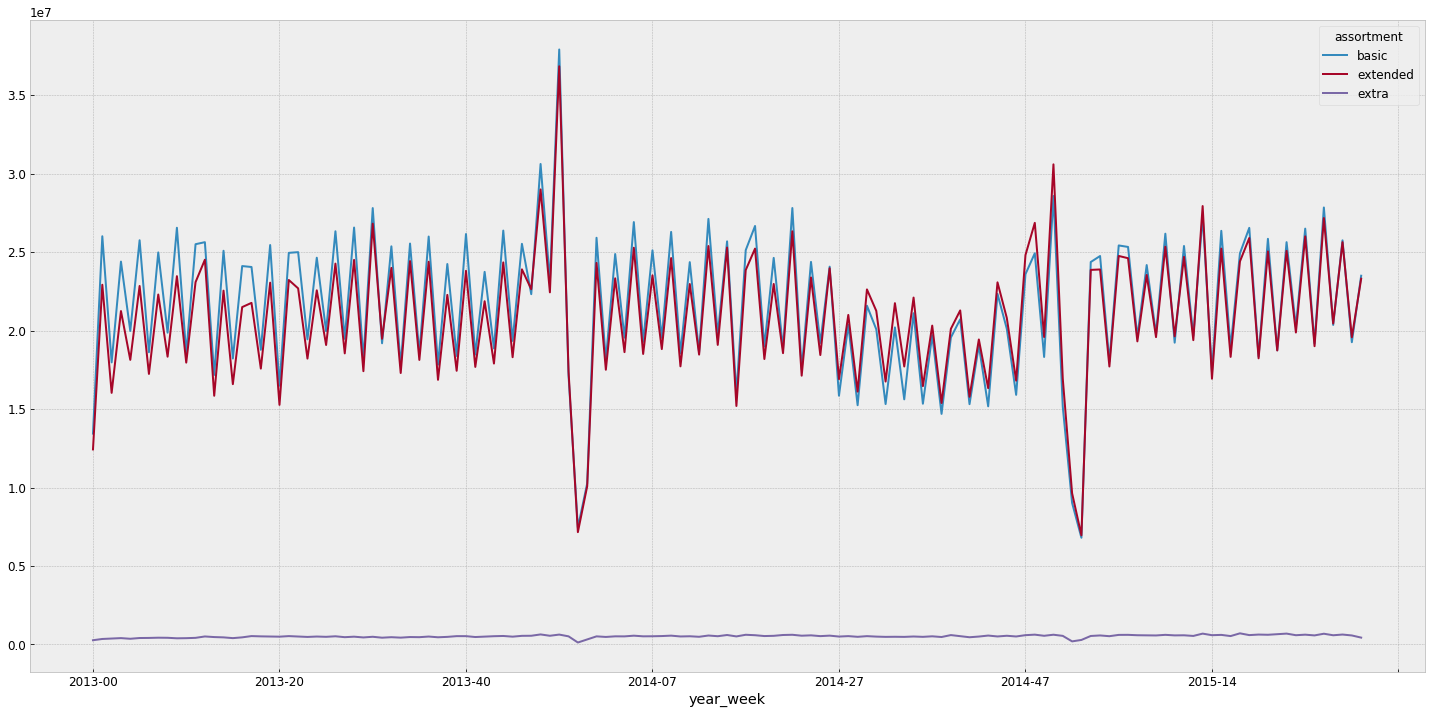

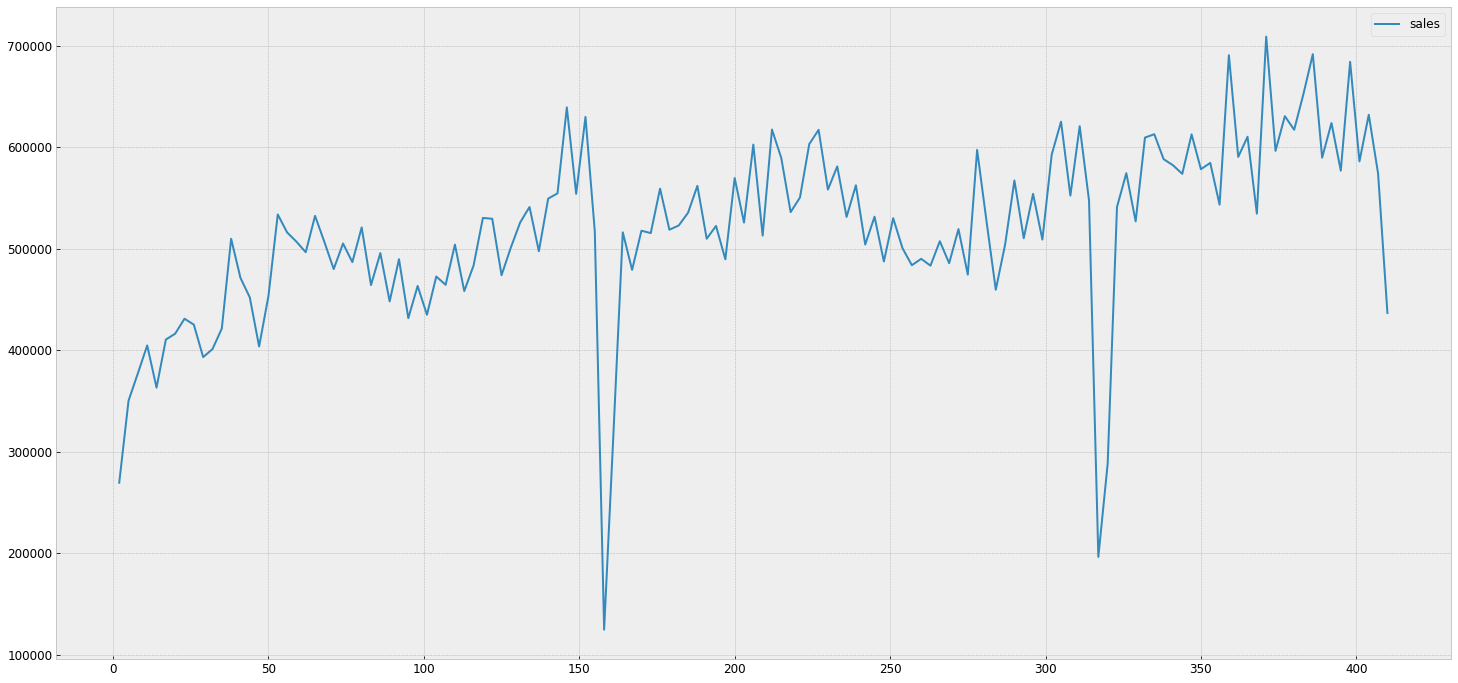

In [89]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
aux3.plot()

### H2. Stores with closest competitors should be selling less

* FALSE, the closest the competition is of the store, the more it sells.

In [295]:
df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

,competition_distance,sales
0,20,4579807
1,30,17552666
2,40,29261626
3,50,60835848
4,60,22088359
...,...,...
650,46590,3554993
651,48330,3798660
652,58260,5718883
653,75860,6896821


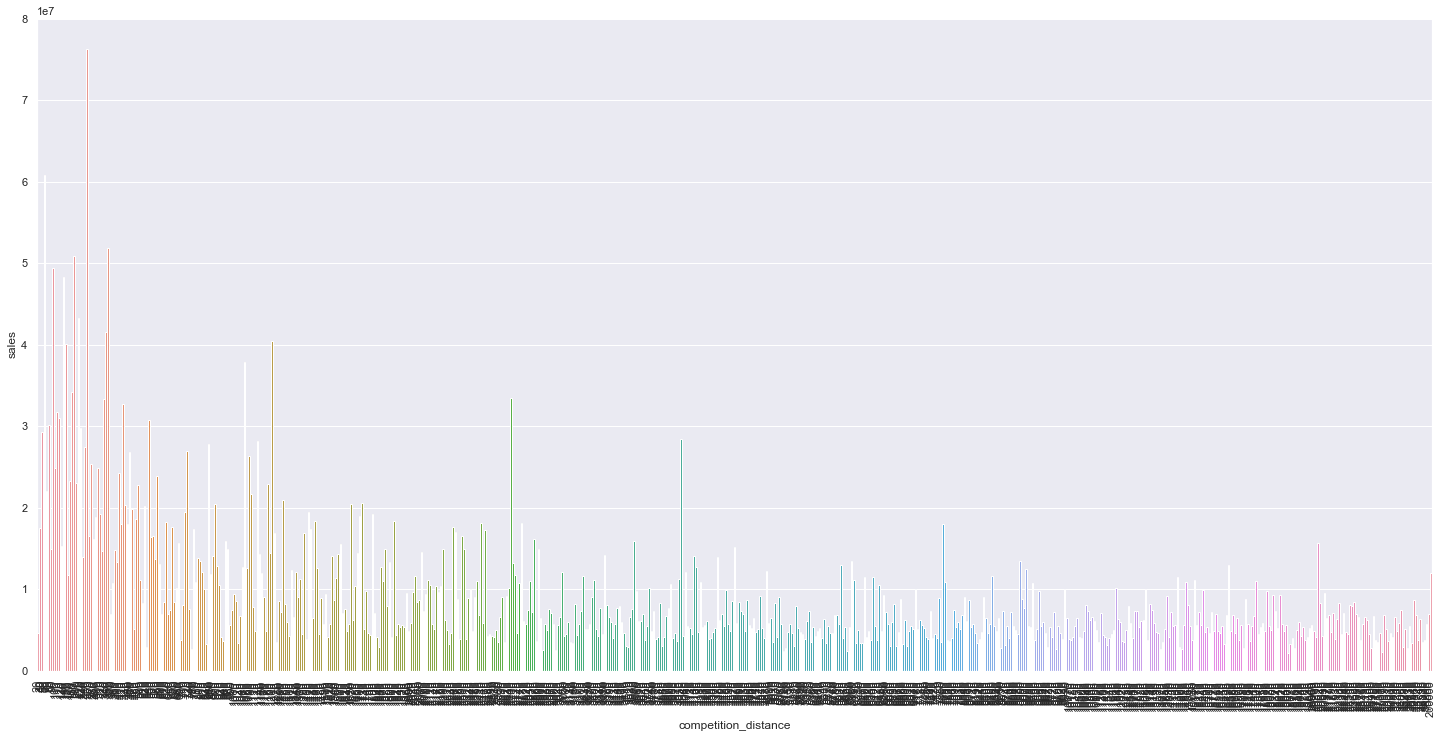

In [296]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance', y='sales', data=aux1)

# Dados muito grranulares ficam desagradáveis de visualizar

In [298]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1.sample(5)

# plt.figure(figsize=(30,10))
# sns.barplot(x='competition_distance', y='sales', data=aux1)

,competition_distance,sales,competition_distance_binned
336,4700,6484095,"(4000, 5000]"
216,2540,3465390,"(2000, 3000]"
243,3000,2541355,"(2000, 3000]"
492,10690,8029269,"(10000, 11000]"
479,9790,5415918,"(9000, 10000]"


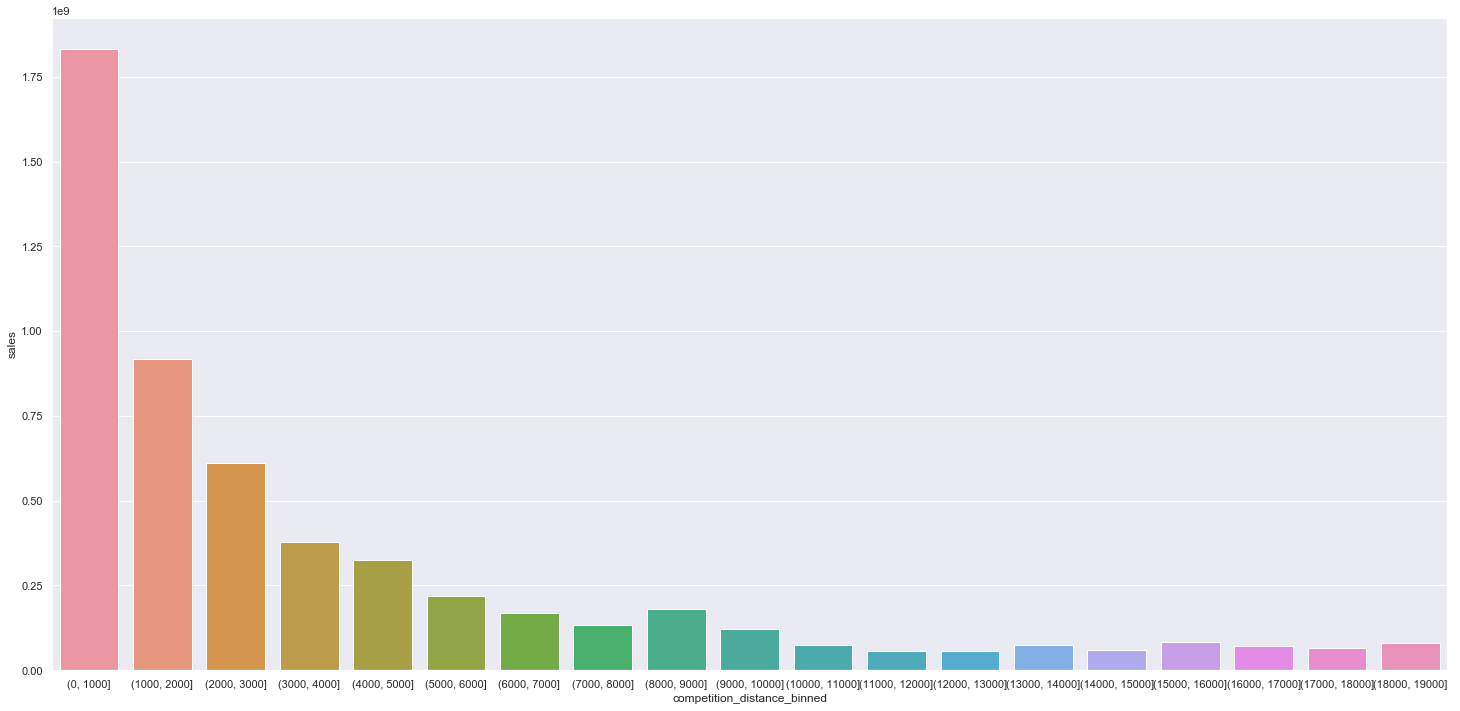

In [299]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

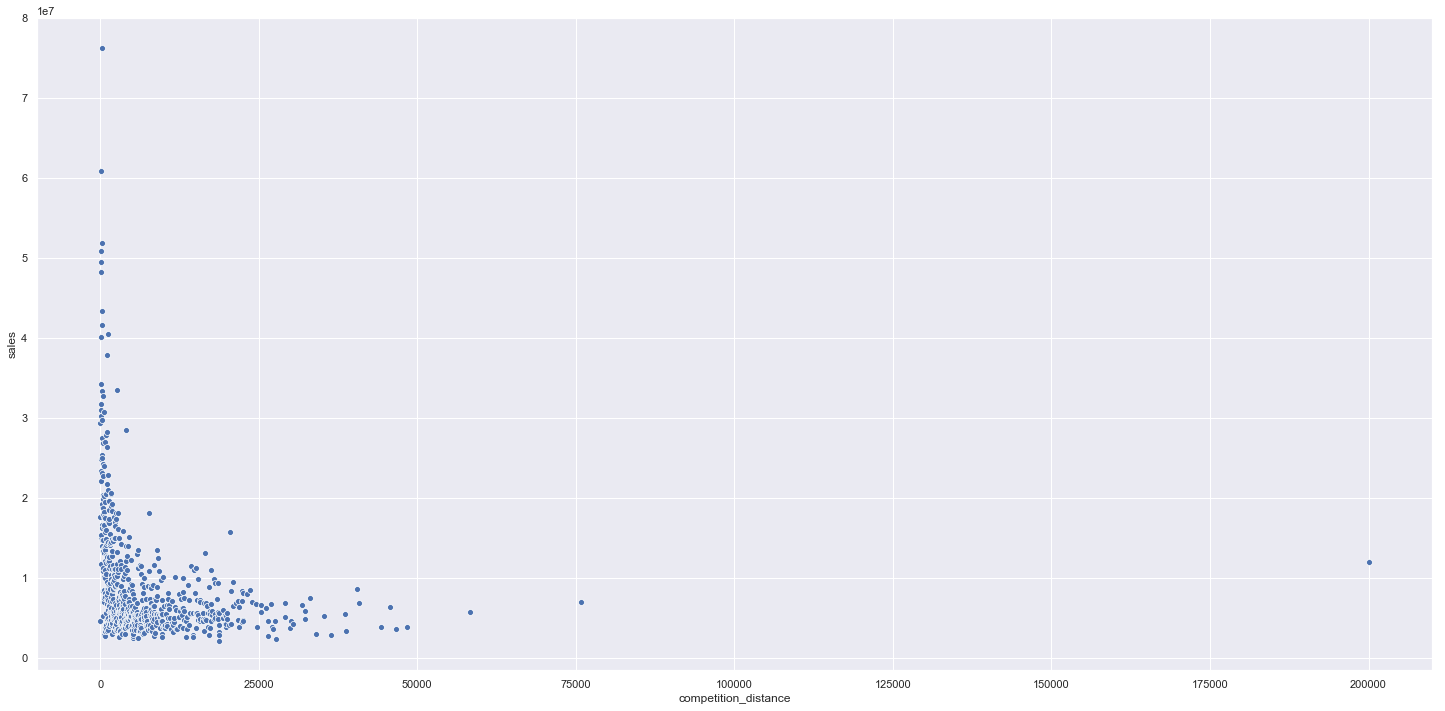

In [300]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
# bins = list(np.arange(0,20000,1000))
# aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
# plt.figure(figsize=(30,10))
# sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

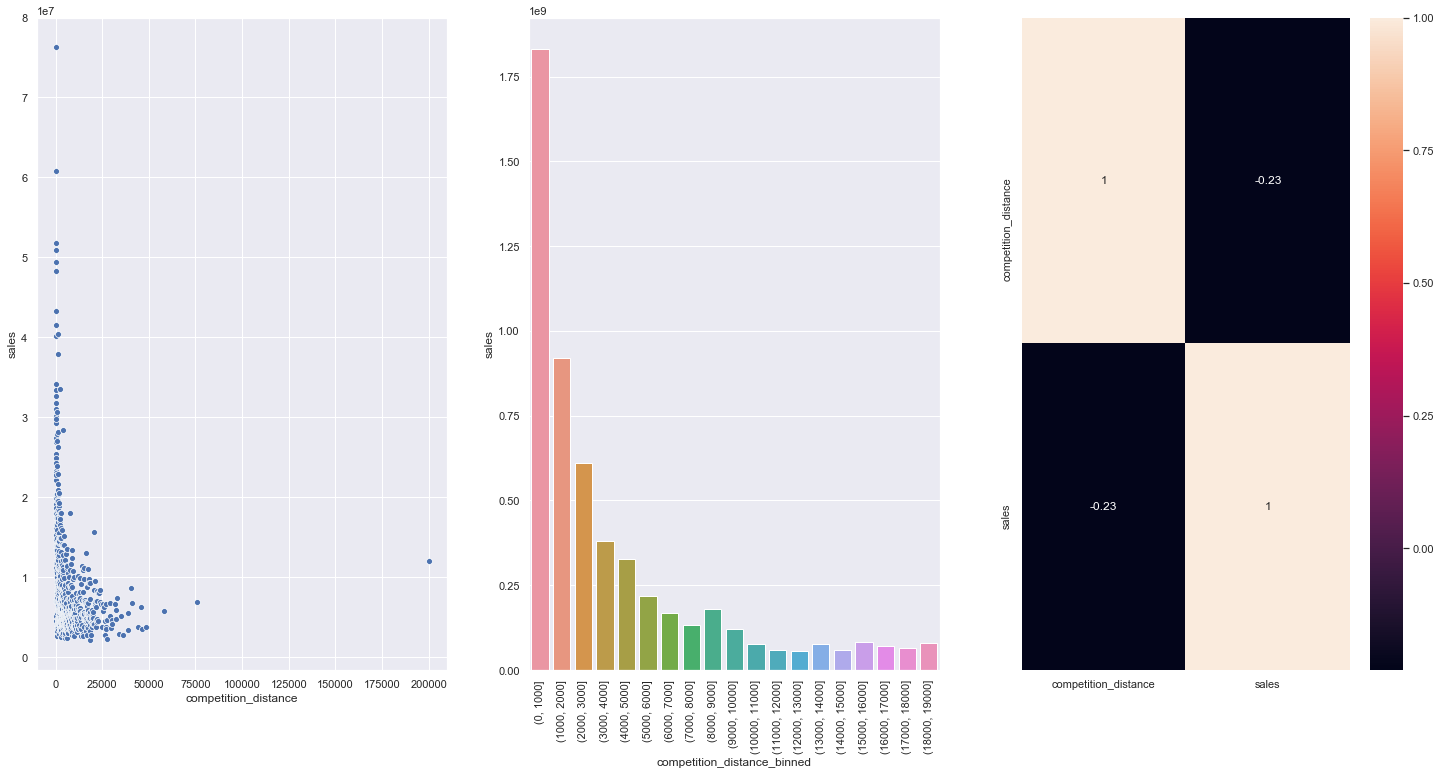

In [301]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Stores with older competitors should sell more

* FALSE, the earliest the time of competition opening, the more the store tends to sell.

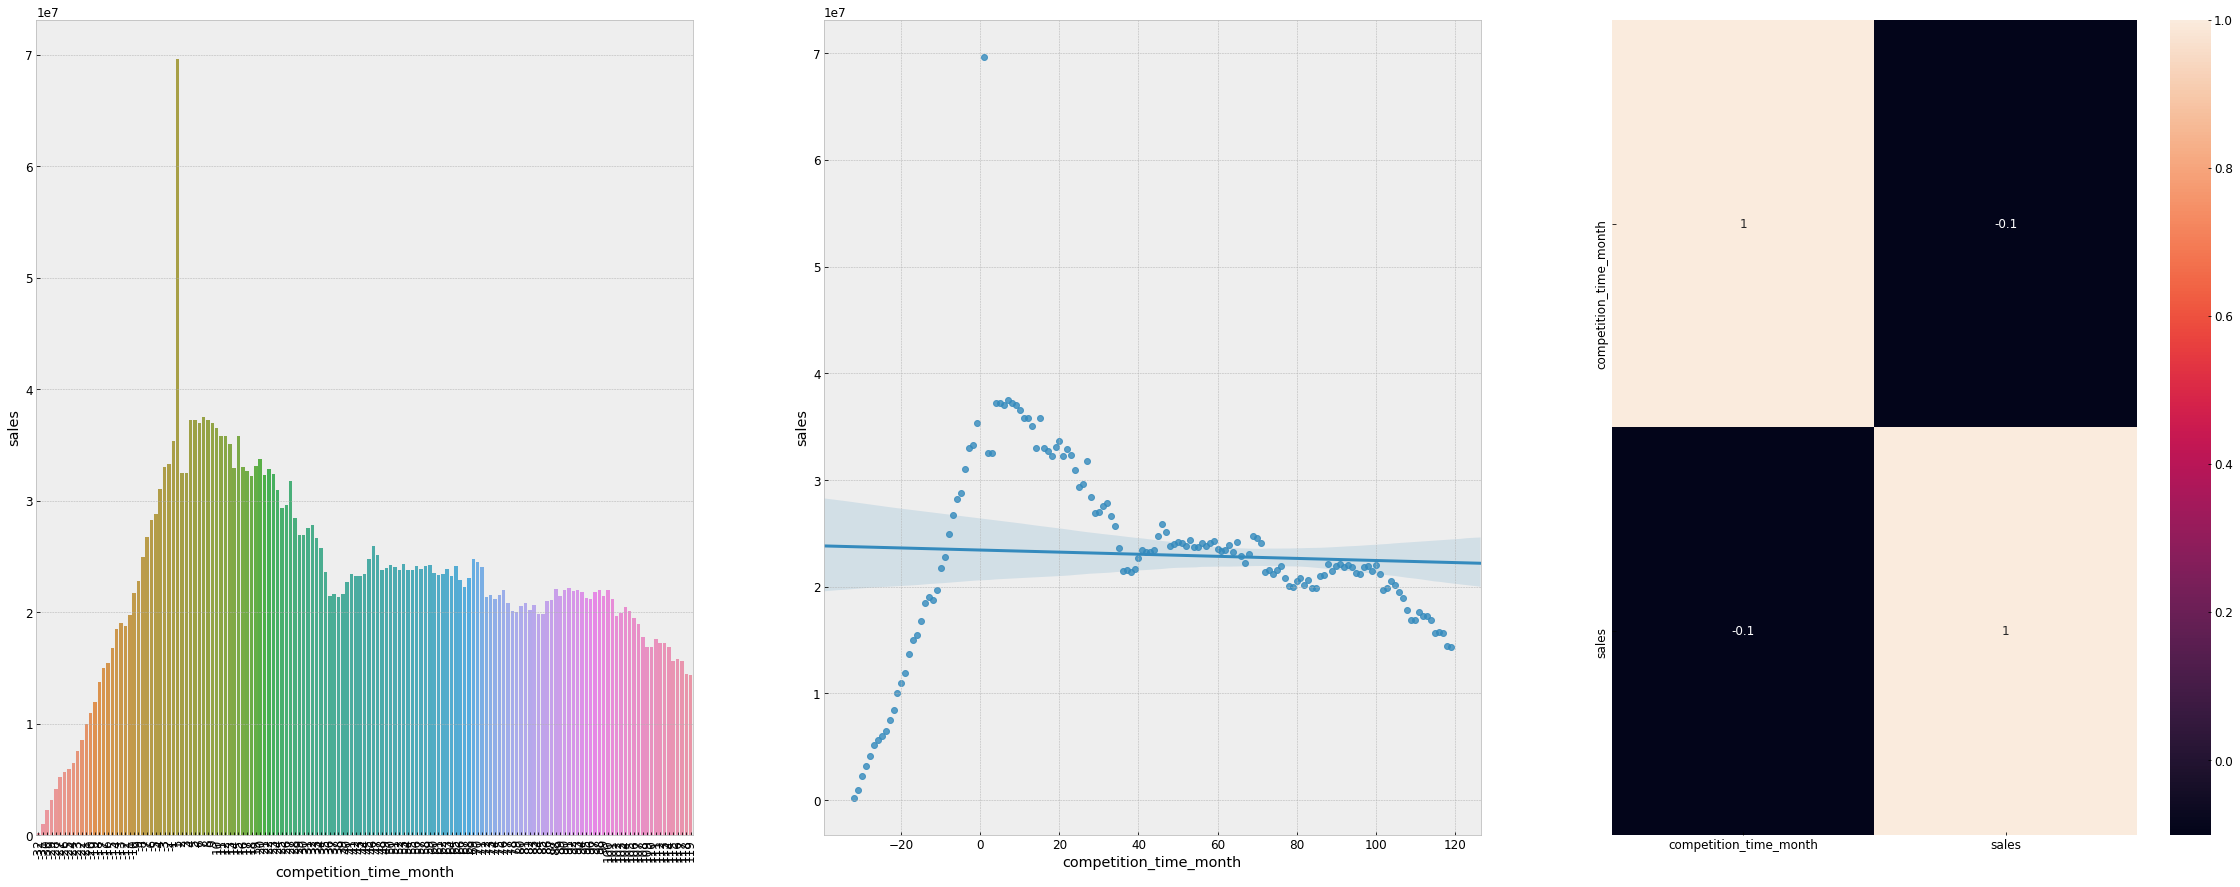

In [97]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.figure(figsize=(40,15))
plt.subplot(1,3,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

## 4.3. Multivariate analysis

* Occam´s Razor:  Sempre escolher o modelo de menor complexidade, pois ele generaliza o aprendizado.
* Vetores linearmente independentes podem ser excluidos.

### 4.3.1. Numerical Attributes

In [98]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_the_year                         int64
year_week                               object
competition_s

In [99]:
num_attributes = df4.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [100]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_the_year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,5263,1,1,1270,9,2008,0,31,2015,0,2015,7,31,31,1220227200000,84,1437955200000,0
1,2,5,6064,1,1,570,11,2007,1,13,2010,1,2015,7,31,31,1193875200000,94,1269216000000,279
2,3,5,8314,1,1,14130,12,2006,1,14,2011,1,2015,7,31,31,1164931200000,105,1301270400000,226
3,4,5,13995,1,1,620,9,2009,0,31,2015,0,2015,7,31,31,1251763200000,71,1437955200000,0
4,5,5,4822,1,1,29910,4,2015,0,31,2015,0,2015,7,31,31,1427846400000,4,1437955200000,0


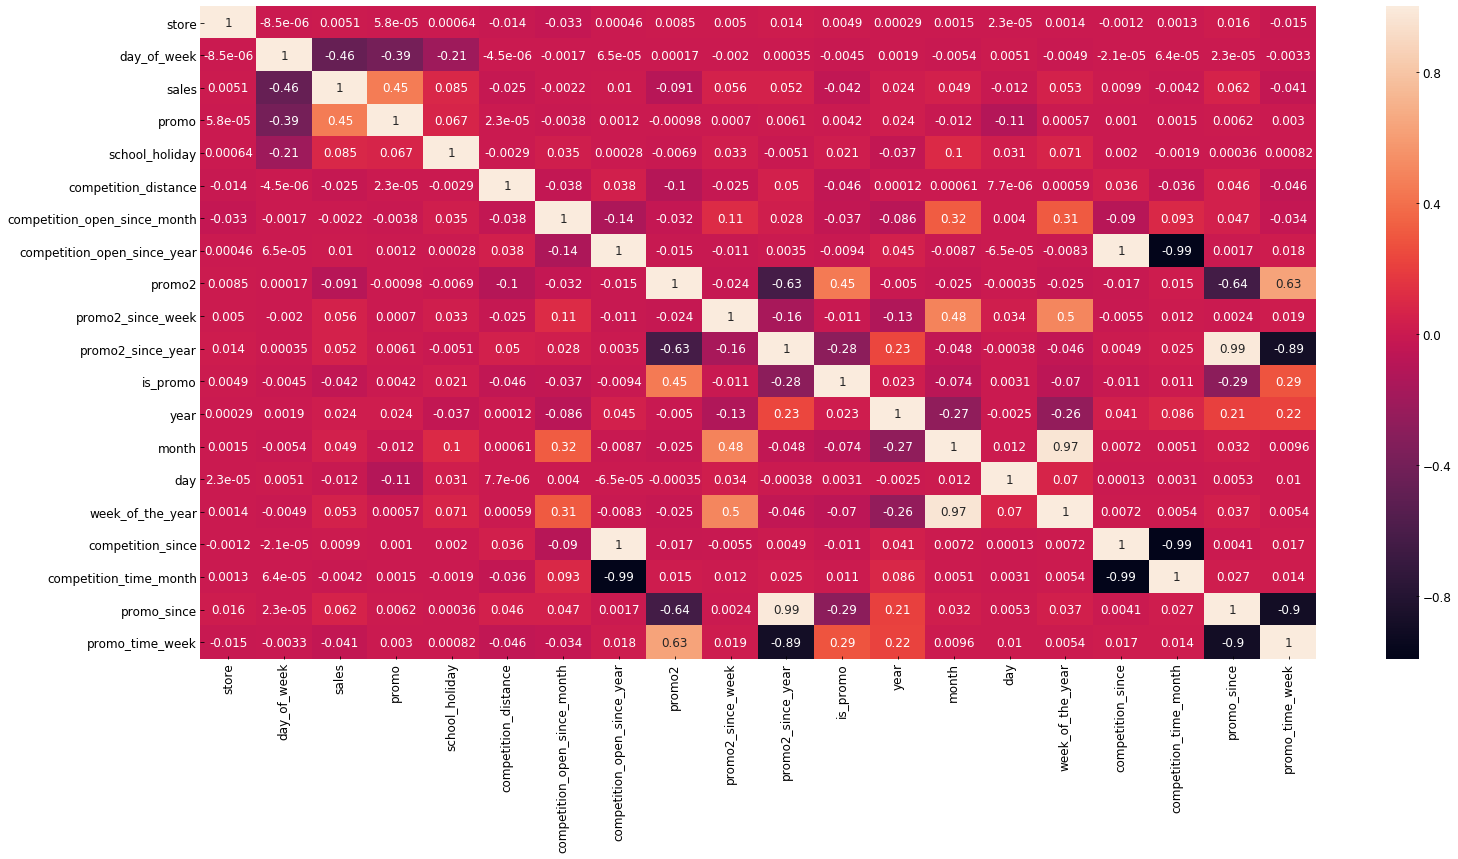

In [101]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.1. Categorical Attributes

In [102]:
import scipy.stats as ss

In [103]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,Regular day,c,basic,2015-30
1,Regular day,a,basic,2015-30
2,Regular day,a,basic,2015-30
3,Regular day,c,extended,2015-30
4,Regular day,a,basic,2015-30


#### Cramer´s V

In [104]:
a = cat_attributes
a.head()

,state_holiday,store_type,assortment,year_week
0,Regular day,c,basic,2015-30
1,Regular day,a,basic,2015-30
2,Regular day,a,basic,2015-30
3,Regular day,c,extended,2015-30
4,Regular day,a,basic,2015-30


In [105]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values
cm

array([[  2240,     66,    564,   1230],
       [  3612,    102,    888,   2088],
       [ 10833,    290,   2630,   6507],
       [534942,  15372, 132758, 303087]], dtype=int64)

In [106]:
n = cm.sum()
n

1017209

In [107]:
r, k = cm.shape
r, k

(4, 4)

In [108]:
ss.chi2_contingency(cm)[0]

21.996648883261916

In [109]:
chi2 = ss.chi2_contingency(cm)[0]
chi2

21.996648883261916

In [110]:
cramers_v = np.sqrt((chi2/n) / (min(k-1,r-1)))
cramers_v

0.0026848036951921026

In [111]:
def cramer_v (x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

In [112]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

In [113]:
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)

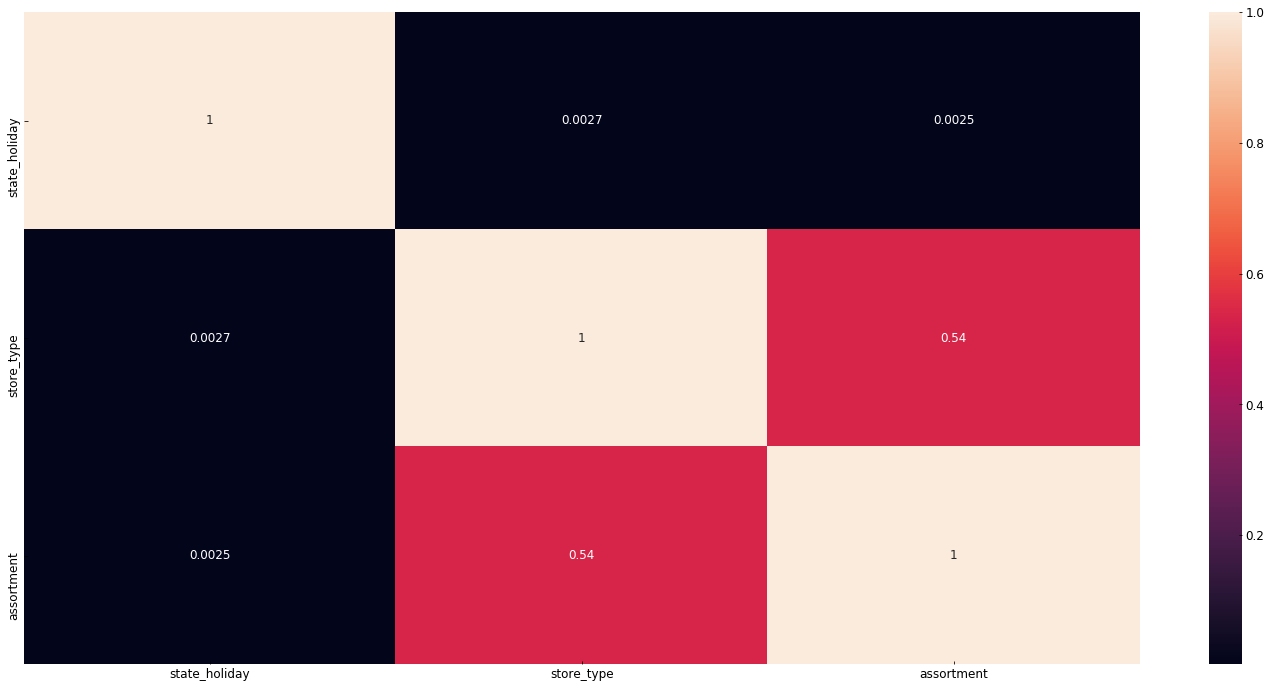

In [114]:
sns.heatmap(d, annot=True)

# 5. Data Preparation

In [64]:
df5 = df4.copy()

In [65]:
a = df5.select_dtypes(include=['int64', 'int32' , 'float64'])

## 5.1. Normalization

In [66]:
## There are no gaussian distribution between the numerical features of the dataset and hence no utility in normalizing any feature

## 5.2. Rescaling

In [67]:
# MinMax
# Robust Scaler

In [68]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910,4,2015,0,31,2015,0,2015,7,31,4,0


c:\users\lucas\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

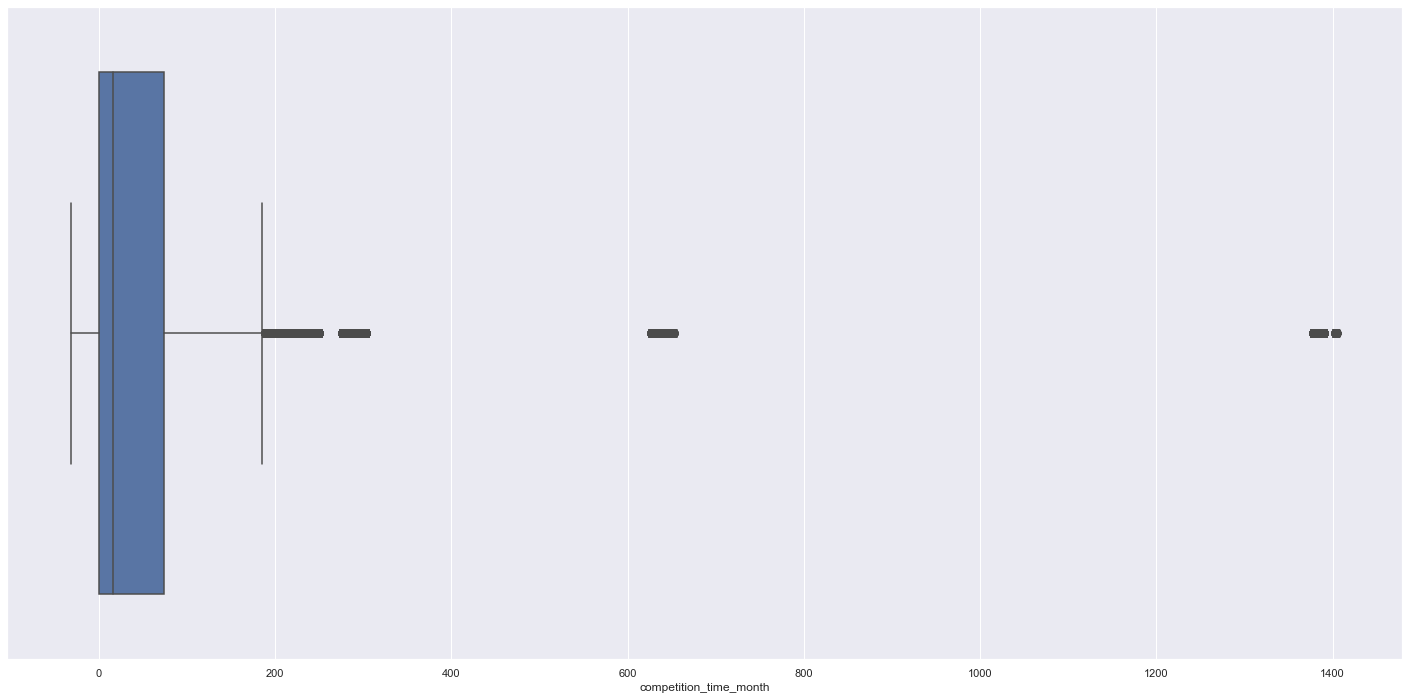

In [69]:
sns.boxplot(a['competition_time_month'])

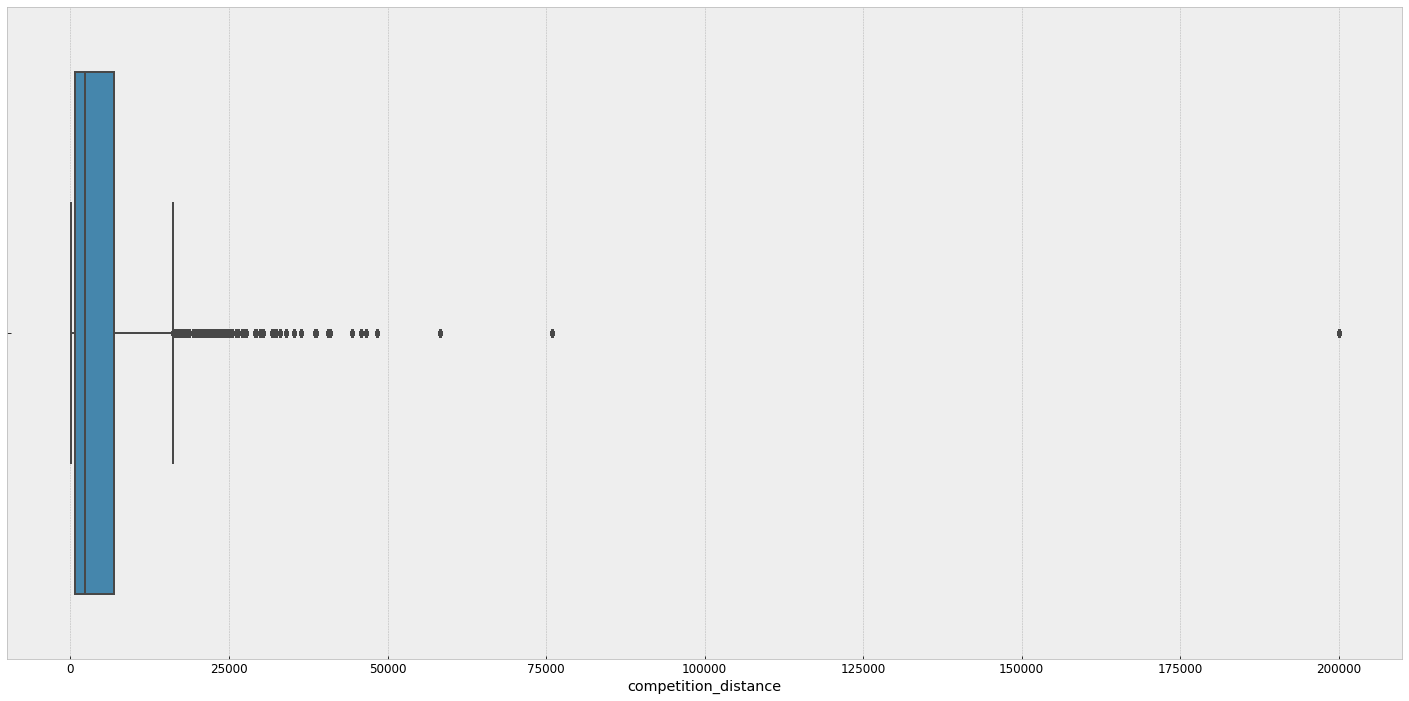

In [220]:
sns.boxplot(a['competition_distance'])

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()

In [70]:
df5['competition_distance'].values.reshape(-1,1)

array([[ 1270],
       [  570],
       [14130],
       ...,
       [  840],
       [ 1430],
       [  720]], dtype=int64)

In [74]:
rs.fit_transform(df5['competition_distance'].values.reshape(-1,1))

array([[-0.17096774],
       [-0.28387097],
       [ 1.90322581],
       ...,
       [-0.24032258],
       [-0.14516129],
       [-0.25967742]])

In [75]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5['competition_distance'].values.reshape(-1,1))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5['competition_time_month'].values.reshape(-1,1))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5['promo_time_week'].values.reshape(-1,1))

# year
df5['year'] = mms.fit_transform(df5['year'].values.reshape(-1,1))

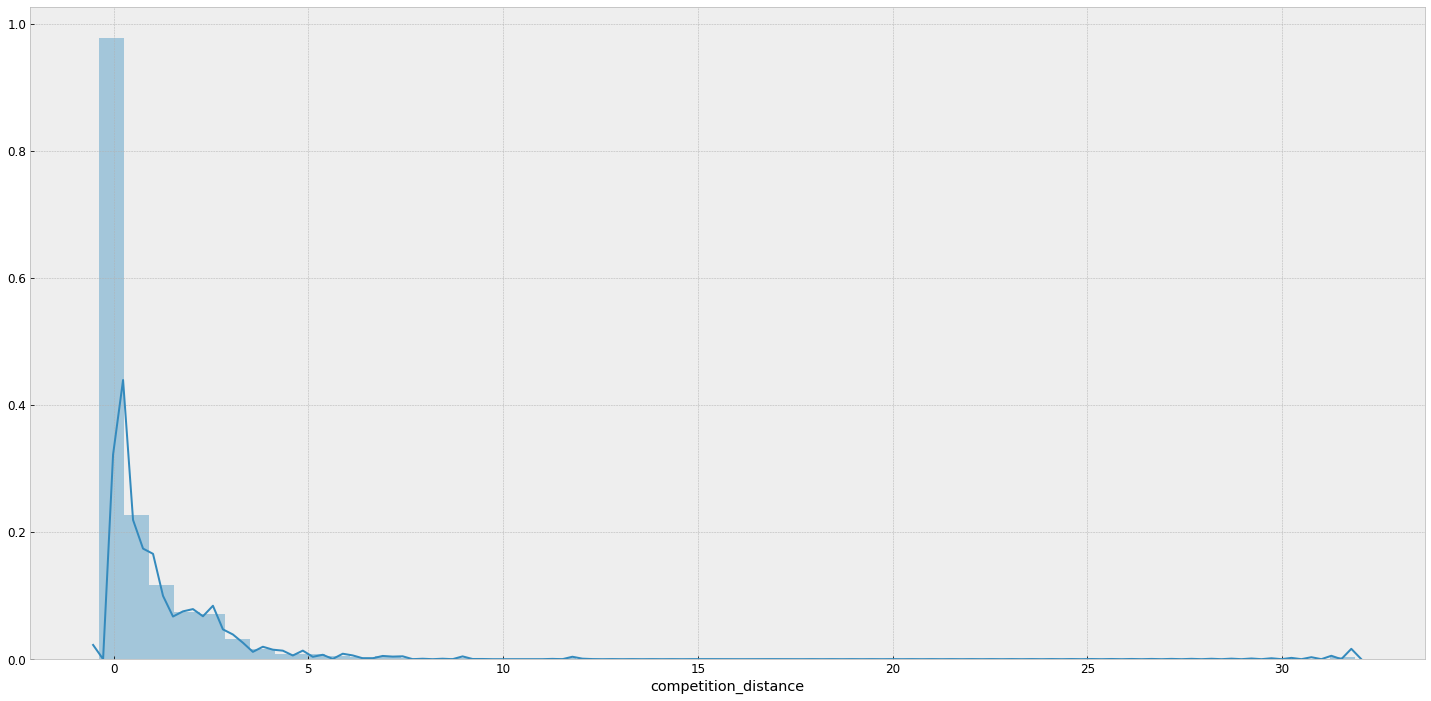

In [225]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformation

### 5.3.1. Enconding

* One Hot Encoding (or dummie)

transforma cada variavel categorica em uma nova coluna binaria

* Label Encoding

transforma cada variavel categorica em um numero sequencial, correspondente à mesma

* Ordinal Encoding

correspondente ao label, mas a ordem dos numeros corresponde a uma ordem intrinseca das categorias

* Target Encoding

para muitos niveis de variaveis categoricas, como cores. Ex: a cada cor corresponde um valor de vendas, divide-se o valor medio de vendas para cada cor e se atribui esse valor de vendas por exemplo a variavel. Por isso 'target', que seria um valor correspondente a variavel.

* Frequency Encoding

parecido com o target, mas assume o valor correspondente a quanto cada variavel se repete.

* Embedding Encoding


In [76]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [77]:
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [78]:
# assortment
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

* Logarithm Transformation
* Box-Cox Transformation
* Cube-Root transformation
* Square-Root Transformation
* Sine and Cosine Transformation

In [79]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [80]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

In [81]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

In [82]:
# week_of_the_year
df5['week_of_the_year_sin'] = df5['week_of_the_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_the_year_cos'] = df5['week_of_the_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [83]:
df5.shape

(844338, 36)

# 6. Feature Selection ( and train_test_split)

* ***Principio Occam´s Razor:*** A explicação mais simples sobre um fenomeno observado deveria prevalecer sobre explicações mais complexas.

Tipos de seleção de variaveis:

***1. Seleção Univariada (Filter Methods):***
Vai classificar as features relevantes com base no Coeficiente de Correlação.

* Vantagens: Simples, rápido, de fácil entendimento.
* Não considera a influencia entre as variáveis (pode excluir variaveis que quando combinadas com outras pode ter uma correlação forte).

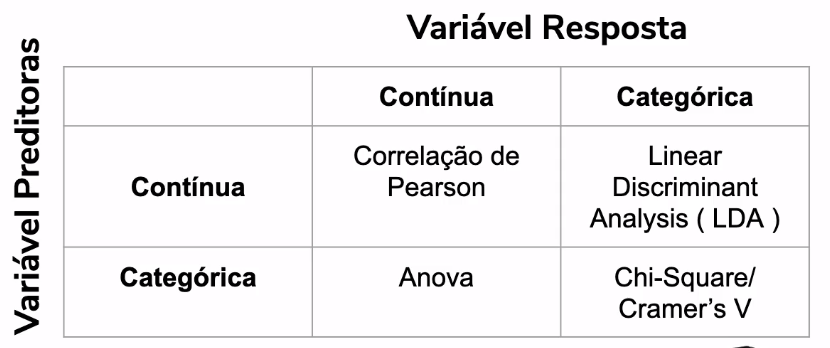

In [243]:
Image('img/selec_uni.png')

***2. Seleção por importância (Embedded Methods):***
Esse metodo de seleção de features é o subproduto do proprio sistema de aprendizado de alguns modelos.

1. Random Forest:

Gini Impurity. Importance score.

2. Lasso Regression
Similar to Random, but normalized
3. Ridge Regression
Similar to Random, but normalized

***3. seleção por SubSet (Wrapper Methods):***
    'Selection process: select, train, view performance. Did it increase performance? if yes, add another feature and repeat. Variables that don´t increase performance are removed. All variables are tested.'
    
1. Boruta


In [84]:
df6 = df5.copy()

In [85]:
df6.to_json('csv/df6.json')

In [7]:
df6 = pd.read_json('csv/df6.json')

In [8]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_the_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_Christmas', 'state_holiday_Easter holiday',
       'state_holiday_Public holiday', 'state_holiday_Regular day',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_the_year_sin',
       'week_of_the_year_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [86]:
cols_drop = ['year', 'month', 'day', 'week_of_the_year', 'promo_since', 'competition_since', 'year_week'] # faltou ''day_of_week'

In [87]:
df6 = df6.drop(cols_drop, axis=1)

In [88]:
# Train and test split based in time, takingthe last six weeks as test data
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

## 6.1. Train Test Split

In [89]:
## train
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [90]:
print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Training min date: {}'.format(X_test['date'].min()))
print('Training max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Training min date: 2015-06-19 00:00:00
Training max date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selection

In [91]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [267]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	8


In [268]:
boruta.support_

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True])

In [273]:
cols_selected = boruta.support_.tolist()

# best features from boruta
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

In [274]:
cols_selected_boruta

['store',
 'day_of_week',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_the_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [92]:
Cols_selected_boruta = ['store',
 'day_of_week',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_the_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [111]:
Cols_selected_boruta

['store',
 'day_of_week',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_the_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [42]:
cols_selected = [ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True]

## 6.2. Manual Feature Selection

In [112]:
cols_selected_boruta = [
     'store',
     'day_of_week',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_the_year_sin', 
     'week_of_the_year_cos',
     'day_of_week_sin',
     'day_of_week_cos']

# columns to add
feat_to_add = ['date' ,'sales'] 

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [113]:
cols_selected_boruta

['store',
 'day_of_week',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_the_year_sin',
 'week_of_the_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7. ML models

In [114]:
X_train = X_train[cols_selected_boruta]
X_test = X_test[cols_selected_boruta]

In [115]:
X_train.head()

,store,day_of_week,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_the_year_sin,week_of_the_year_cos,day_of_week_sin,day_of_week_cos
47945,1,4,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,4,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,4,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,4,1,2,2,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,4,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


## 7.1. Average Model

In [116]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()
aux1.head()

,store,day_of_week,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_the_year_sin,week_of_the_year_cos,day_of_week_sin,day_of_week_cos,sales
0,1,5,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.568646
1,2,5,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.710290
2,3,5,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,9.025816
3,4,5,1,2,2,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,9.546527
4,5,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.481151


In [117]:
# 'prediction'        is the result of the 'mean' in the groupby function, by store
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']
aux1.head()

,store,day_of_week,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_the_year_sin,week_of_the_year_cos,day_of_week_sin,day_of_week_cos,sales,predictions
0,1,5,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.568646,8.373392
1,2,5,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.710290,8.460676
2,3,5,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,9.025816,8.795885
3,4,5,1,2,2,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,9.546527,9.194715
4,5,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521,8.481151,8.346624


In [100]:
# performance
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])

In [101]:
# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [102]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1854.691318,0.290129,2652.608872


### 7.2.1. Linear Regression - Cross Validation

In [105]:
lr_result_cv = cross_validation(X_train, 5, 'Linear Regression', lr, verbose=False)

KeyError: 'date'

In [154]:
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2070.19+/-289.42,0.3+/-0.02,2937.56+/-461.52


## 7.3. Linear Regression Regularized Model - Lasso

In [71]:
# model
lrr = Lasso(alpha=0.001).fit(X_train, y_train)

# prediction
yhat_lrr = lrr.predict(X_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result # acrescentando o bias correspondente ao lambda ou alpha da regressão 'Lasso', a soma dos erros aumenta ainda mais para o RMSE

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1854.68798,0.285128,2673.923973


### 7.3.1. Lasso - Cross Validation

In [155]:
lrr_result_cv = cross_validation(X_train, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

C:\Users\lucas\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1154.9830946161383, tolerance: 11.937395279085088
  positive)


,MAE CV,MAPE CV,RMSE CV
0,2077.27+/-322.51,0.29+/-0.01,2973.5+/-495.23


## 7.4. Random Forest Regressor

In [74]:
# model
rf = RandomForestRegressor(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.227942,0.100004,1013.28932


### 7.4.1. Random Forest Regressor - Cross Validation

In [156]:
rf_result_cv = cross_validation(X_train, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,MAE CV,MAPE CV,RMSE CV
0,827.07+/-213.99,0.11+/-0.02,1236.76+/-312.9


## 7.5. XGBoost Regressor

In [85]:
# model
model_xgb = xgb.XGBRegressor(     objective='reg:squarederror',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytee=0.9).fit(X_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[03:36:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.664027,0.949513,7330.868425


### 7.5.1. XGBoost - Cross Validation

In [157]:
xgb_result_cv = cross_validation(X_train, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

[20:37:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:41:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:50:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only u

,MAE CV,MAPE CV,RMSE CV
0,7047.94+/-587.52,0.95+/-0.0,7713.98+/-688.61


## 7.6. Compare models performances

In [87]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.227942,0.100004,1013.289320
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1854.691318,0.290129,2652.608872
0,Linear Regression - Lasso,1854.687980,0.285128,2673.923973
0,XGBoost Regressor,6683.664027,0.949513,7330.868425


In [100]:
## train
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Training min date: {}'.format(X_test['date'].min()))
print('Training max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Training min date: 2015-06-19 00:00:00
Training max date: 2015-07-31 00:00:00


In [101]:
X_training = X_train[cols_selected_boruta_full]

## 7.7 Cross-Validation

In [113]:
X_training['date'].max()

Timestamp('2015-06-18 00:00:00')

In [114]:
X_training['date'].min()

Timestamp('2013-01-01 00:00:00')

In [116]:
X_training['date'].max() - X_training['date'].min()

Timedelta('898 days 00:00:00')

In [122]:
# start and end date for validation
k = 1
validation_start_date = X_training['date'].max() - datetime.timedelta(days=k*6*7)
validation_end_date = X_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

print(X_training['date'].min())
print(validation_start_date)
print(validation_end_date)

2013-01-01 00:00:00
2015-05-07 00:00:00
2015-06-18 00:00:00


In [123]:
# start and end date for validation
k = 2
validation_start_date = X_training['date'].max() - datetime.timedelta(days=k*6*7)
validation_end_date = X_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

print(X_training['date'].min())
print(validation_start_date)
print(validation_end_date)

2013-01-01 00:00:00
2015-03-26 00:00:00
2015-05-07 00:00:00


In [124]:
# filtering dataset
training = X_training[X_training['date'] < validation_start_date]
validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date )]

In [125]:
print(training['date'].min())
print(training['date'].max())
print(validation['date'].min())
print(validation['date'].max())

2013-01-01 00:00:00
2015-03-25 00:00:00
2015-03-26 00:00:00
2015-05-07 00:00:00


In [109]:
def cross_validation(X_training, kfold, model_name, model, verbose=False):   
    mae = []
    mape = []
    rmse = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('KFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = X_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    
        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date )]
    
        # training and validating dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validating
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        model = model.fit(xtraining, ytraining)
    
        # predictions
        yhat = model.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))
    
        # Store performance of ech iteration
        mae.append(m_result['MAE'])
        mape.append(m_result['MAPE'])
        rmse.append(m_result['RMSE'])
    return pd.DataFrame({'MAE CV': np.round(np.mean(mae), 2).astype(str) + '+/-' + np.round(np.std(mae), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape), 2).astype(str) + '+/-' + np.round(np.std(mape), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse), 2).astype(str) + '+/-' + np.round(np.std(rmse), 2).astype(str)}, index=[0])

In [110]:
model = LinearRegression()
cross_validation(X_training, 5, 'Linear Regression', model)

NameError: name 'X_training' is not defined

In [13]:
model = Lasso()
cross_validation(X_training, 5, 'Lasso', model)

NameError: name 'cross_validation' is not defined

# 8. Hyperparameter Fine Tuning

# 9. Error interpretation

# 10. Model Deploy

# 11. Telegram Bot